In [1]:
# Ethereum Transaction Graph Analysis
# Load required libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [2]:
# Load the Ethereum transaction data
df = pd.read_csv('ethereum_small.csv')

print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print(f"\nDate range: {df['transaction_day'].min()} to {df['transaction_day'].max()}")
print(f"Root node: {df['root_node'].iloc[0]}")
print(f"Unique addresses: {len(set(df['from_address'].unique()) | set(df['to_address'].unique()))}")


Data loaded successfully!
Dataset shape: (149, 7)
Columns: ['hash', 'block_number', 'from_address', 'to_address', 'value', 'transaction_day', 'root_node']

First few rows:
                                                hash  block_number  \
0  0xe835bb92c72224384a71dc64e02e4c2865aeb2cf46af...      23445231   
1  0x6db3a5f67c66c9c21ef439f493a56e7c3f918975e5da...      23540474   
2  0xe1aafc49dd3559b4d0f8daefed9379a8f5a7b5230531...      23506006   
3  0x8f4358ed7b87b0f8cc629fcda5fde5bb5a3937eeabd9...      23453491   
4  0x0af0bbe59fd8c7ae98421360b805d5153294c55bc4d8...      23453729   

                                 from_address  \
0  0x48cce57c4d2dbb31eaf79575abf482bbb8dc071d   
1  0xdc57e657af7554c5d5bf8937650329931bbc5582   
2  0x8aee90d162bc7a53a2904d74bc48d6dc3ba1db6c   
3  0x88640183d9d0a7bff090129713784e42db7b7779   
4  0x2d34816c3c83554ce97144c623c381b303aba732   

                                   to_address               value  \
0  0xa2a786ff9148f7c88ee93372db8cbe9e94585c

In [3]:
# Construct the directed graph with edge features
G = nx.DiGraph()

# Add all unique addresses as nodes
all_addresses = set(df['from_address'].unique()) | set(df['to_address'].unique())
G.add_nodes_from(all_addresses)

print(f"Added {len(all_addresses)} nodes to the graph")

# Group transactions by edge (from_address, to_address)
edge_data = df.groupby(['from_address', 'to_address']).agg({
    'value': ['count', 'sum', 'mean'],
    'hash': 'count'
}).reset_index()

# Flatten column names
edge_data.columns = ['from_address', 'to_address', 'transaction_count', 'total_value', 'avg_value', 'hash_count']

# Add edges with attributes
for _, row in edge_data.iterrows():
    G.add_edge(
        row['from_address'], 
        row['to_address'],
        transaction_count=row['transaction_count'],
        total_value=row['total_value'],
        avg_value=row['avg_value']
    )

print(f"Added {G.number_of_edges()} edges to the graph")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Added 91 nodes to the graph
Added 92 edges to the graph
Graph has 91 nodes and 92 edges


In [4]:
# Calculate comprehensive graph statistics
print("=== GRAPH STATISTICS ===")
print(f"Total transactions (original): {len(df)}")
print(f"Number of nodes (unique addresses): {G.number_of_nodes()}")
print(f"Number of edges (unique address pairs): {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.4f}")

# Degree statistics
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]
total_degrees = [d for n, d in G.degree()]

print(f"\n=== DEGREE STATISTICS ===")
print(f"Average in-degree: {np.mean(in_degrees):.2f}")
print(f"Average out-degree: {np.mean(out_degrees):.2f}")
print(f"Average total degree: {np.mean(total_degrees):.2f}")
print(f"Max in-degree: {max(in_degrees)}")
print(f"Max out-degree: {max(out_degrees)}")
print(f"Max total degree: {max(total_degrees)}")

# Connected components
weakly_connected = list(nx.weakly_connected_components(G))
strongly_connected = list(nx.strongly_connected_components(G))

print(f"\n=== CONNECTIVITY ===")
print(f"Number of weakly connected components: {len(weakly_connected)}")
print(f"Number of strongly connected components: {len(strongly_connected)}")
print(f"Largest weakly connected component size: {len(max(weakly_connected, key=len))}")
print(f"Largest strongly connected component size: {len(max(strongly_connected, key=len)) if strongly_connected else 0}")


=== GRAPH STATISTICS ===
Total transactions (original): 149
Number of nodes (unique addresses): 91
Number of edges (unique address pairs): 92
Graph density: 0.0112

=== DEGREE STATISTICS ===
Average in-degree: 1.01
Average out-degree: 1.01
Average total degree: 2.02
Max in-degree: 75
Max out-degree: 11
Max total degree: 75

=== CONNECTIVITY ===
Number of weakly connected components: 1
Number of strongly connected components: 91
Largest weakly connected component size: 91
Largest strongly connected component size: 1


In [5]:
# Identify hub nodes and high-volume addresses
print("=== HUB ANALYSIS ===")

# Top nodes by degree
degree_dict = dict(G.degree())
top_degree_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes by total degree:")
for i, (node, degree) in enumerate(top_degree_nodes, 1):
    short_addr = f"{node[:8]}...{node[-6:]}"
    print(f"{i:2d}. {short_addr} (degree: {degree})")

# Top nodes by in-degree (receiving most transactions)
in_degree_dict = dict(G.in_degree())
top_in_degree = sorted(in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"\nTop 5 nodes by in-degree (receiving):")
for i, (node, degree) in enumerate(top_in_degree, 1):
    short_addr = f"{node[:8]}...{node[-6:]}"
    print(f"{i}. {short_addr} (in-degree: {degree})")

# Top nodes by out-degree (sending most transactions)
out_degree_dict = dict(G.out_degree())
top_out_degree = sorted(out_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print(f"\nTop 5 nodes by out-degree (sending):")
for i, (node, degree) in enumerate(top_out_degree, 1):
    short_addr = f"{node[:8]}...{node[-6:]}"
    print(f"{i}. {short_addr} (out-degree: {degree})")

# Root node analysis
root_node = df['root_node'].iloc[0]
print(f"\nRoot node analysis:")
print(f"Root: {root_node[:8]}...{root_node[-6:]}")
print(f"Root in-degree: {G.in_degree(root_node)}")
print(f"Root out-degree: {G.out_degree(root_node)}")
print(f"Root total degree: {G.degree(root_node)}")


=== HUB ANALYSIS ===
Top 10 nodes by total degree:
 1. 0xa2a786...585c74 (degree: 75)
 2. 0x8aee90...a1db6c (degree: 12)
 3. 0x6cd2e2...39d9bf (degree: 3)
 4. 0xca519e...a50028 (degree: 3)
 5. 0xac2a0e...89785f (degree: 3)
 6. 0x48b847...9bba72 (degree: 2)
 7. 0x3ac7a6...9c3a55 (degree: 2)
 8. 0x2e5095...c7d1d3 (degree: 1)
 9. 0x01e0b2...14e2f2 (degree: 1)
10. 0x1790b0...95a3e2 (degree: 1)

Top 5 nodes by in-degree (receiving):
1. 0xa2a786...585c74 (in-degree: 75)
2. 0x48b847...9bba72 (in-degree: 2)
3. 0x3ac7a6...9c3a55 (in-degree: 2)
4. 0x6cd2e2...39d9bf (in-degree: 1)
5. 0x3cd61b...f38545 (in-degree: 1)

Top 5 nodes by out-degree (sending):
1. 0x8aee90...a1db6c (out-degree: 11)
2. 0x6cd2e2...39d9bf (out-degree: 2)
3. 0xca519e...a50028 (out-degree: 2)
4. 0xac2a0e...89785f (out-degree: 2)
5. 0x2e5095...c7d1d3 (out-degree: 1)

Root node analysis:
Root: 0x8aee90...a1db6c
Root in-degree: 1
Root out-degree: 11
Root total degree: 12


In [6]:
# Transaction value analysis
print("=== TRANSACTION VALUE ANALYSIS ===")

# Edge value statistics
edge_values = [data['total_value'] for u, v, data in G.edges(data=True)]
edge_counts = [data['transaction_count'] for u, v, data in G.edges(data=True)]

print(f"Total value across all edges: {sum(edge_values):.2e} Wei")
print(f"Average value per edge: {np.mean(edge_values):.2e} Wei")
print(f"Median value per edge: {np.median(edge_values):.2e} Wei")
print(f"Max value per edge: {max(edge_values):.2e} Wei")

print(f"\nAverage transactions per edge: {np.mean(edge_counts):.2f}")
print(f"Max transactions per edge: {max(edge_counts)}")

# Top edges by value
edge_value_list = [(u, v, data['total_value'], data['transaction_count']) 
                   for u, v, data in G.edges(data=True)]
top_value_edges = sorted(edge_value_list, key=lambda x: x[2], reverse=True)[:5]

print(f"\nTop 5 edges by total value:")
for i, (u, v, value, count) in enumerate(top_value_edges, 1):
    u_short = f"{u[:6]}...{u[-4:]}"
    v_short = f"{v[:6]}...{v[-4:]}"
    print(f"{i}. {u_short} → {v_short}: {value:.2e} Wei ({count} txns)")

# Top edges by transaction count
top_count_edges = sorted(edge_value_list, key=lambda x: x[3], reverse=True)[:5]

print(f"\nTop 5 edges by transaction count:")
for i, (u, v, value, count) in enumerate(top_count_edges, 1):
    u_short = f"{u[:6]}...{u[-4:]}"
    v_short = f"{v[:6]}...{v[-4:]}"
    print(f"{i}. {u_short} → {v_short}: {count} txns ({value:.2e} Wei)")


=== TRANSACTION VALUE ANALYSIS ===
Total value across all edges: 3.50e+18 Wei
Average value per edge: 3.81e+16 Wei
Median value per edge: 1.27e+13 Wei
Max value per edge: 1.40e+18 Wei

Average transactions per edge: 1.62
Max transactions per edge: 8

Top 5 edges by total value:
1. 0x37c0...a223 → 0xa2a7...5c74: 1.40e+18 Wei (1 txns)
2. 0x48cc...071d → 0xa2a7...5c74: 9.00e+17 Wei (7 txns)
3. 0xdc8e...42a6 → 0xa2a7...5c74: 6.00e+17 Wei (1 txns)
4. 0x5778...3130 → 0xa2a7...5c74: 3.00e+17 Wei (5 txns)
5. 0x936e...e738 → 0xa2a7...5c74: 1.00e+17 Wei (1 txns)

Top 5 edges by transaction count:
1. 0xc6d2...100e → 0xa2a7...5c74: 8 txns (6.19e+13 Wei)
2. 0xa577...81a3 → 0xa2a7...5c74: 8 txns (8.69e+13 Wei)
3. 0x48cc...071d → 0xa2a7...5c74: 7 txns (9.00e+17 Wei)
4. 0x5778...3130 → 0xa2a7...5c74: 5 txns (3.00e+17 Wei)
5. 0xd298...c831 → 0xa2a7...5c74: 4 txns (5.45e+14 Wei)


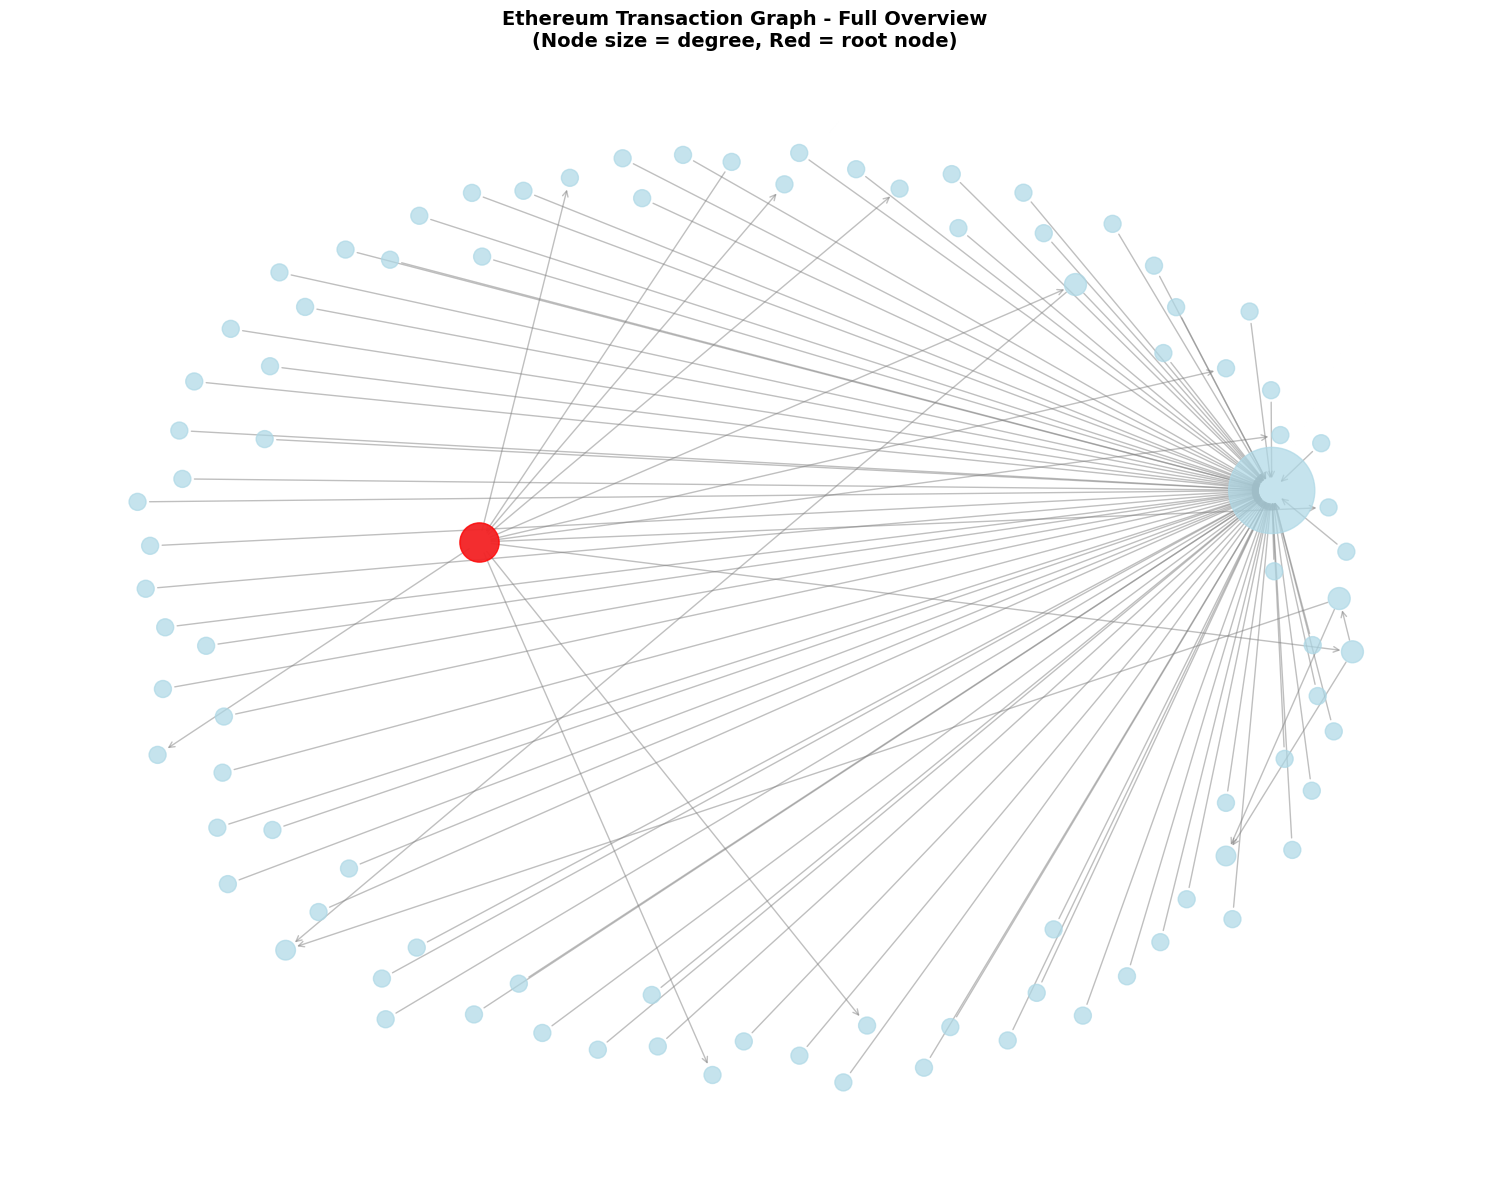

Full graph visualization complete!
Red node is the root: 0x8aee90...a1db6c


In [7]:
# Visualization 1: Full Graph Overview
plt.figure(figsize=(15, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G, k=3, iterations=50)

# Calculate node sizes based on degree
node_sizes = [G.degree(node) * 50 + 100 for node in G.nodes()]

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                      node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray', arrows=True, 
                      arrowsize=10, arrowstyle='->')

# Highlight the root node
root_node = df['root_node'].iloc[0]
if root_node in G.nodes():
    nx.draw_networkx_nodes(G, pos, nodelist=[root_node], 
                          node_size=G.degree(root_node) * 50 + 200,
                          node_color='red', alpha=0.8)

plt.title('Ethereum Transaction Graph - Full Overview\n(Node size = degree, Red = root node)', 
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Full graph visualization complete!")
print(f"Red node is the root: {root_node[:8]}...{root_node[-6:]}")


Ego graph around root node:
Nodes in ego graph: 16
Edges in ego graph: 17


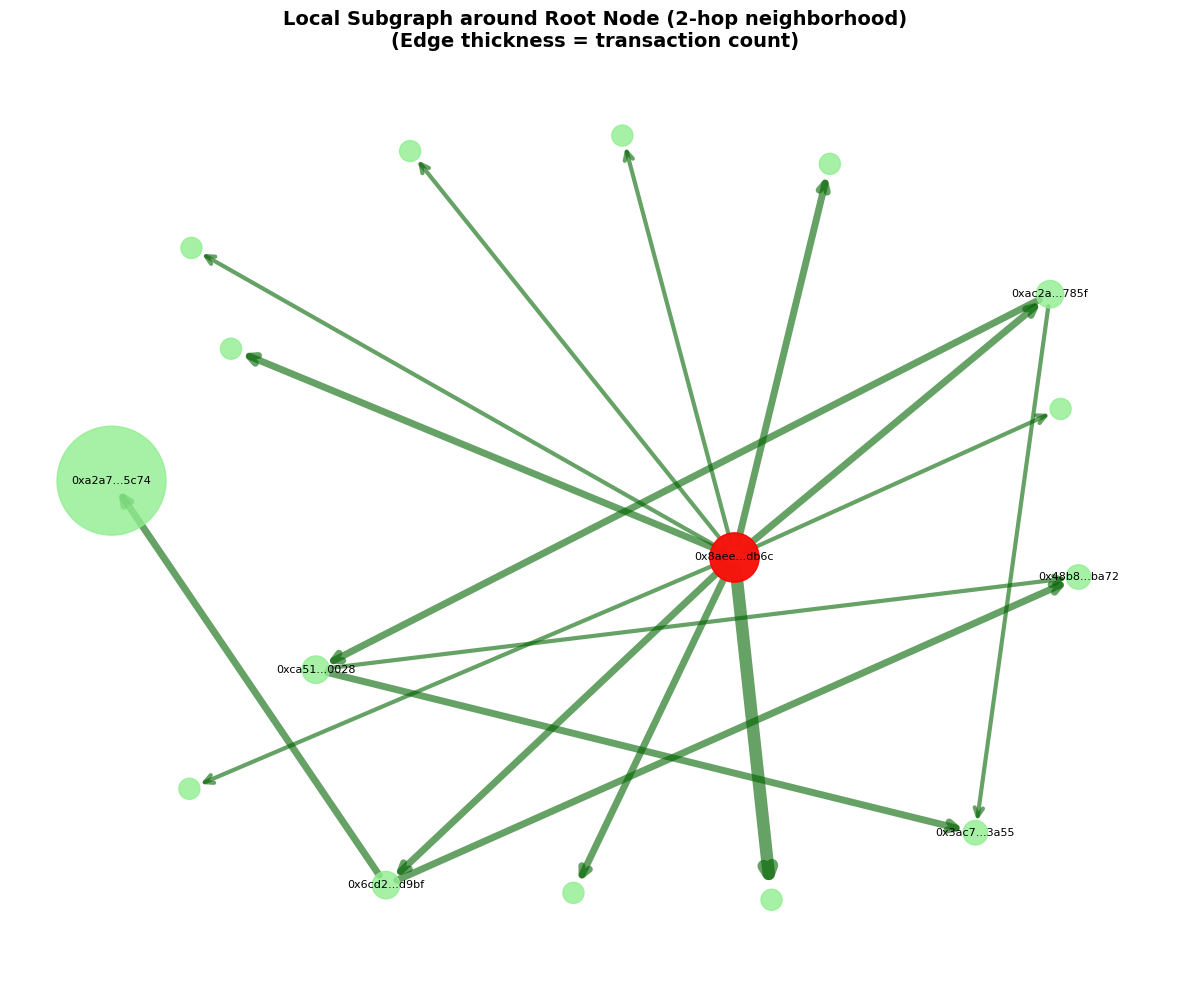

In [8]:
# Visualization 2: Local Subgraph around Root Node (2-hop neighborhood)
plt.figure(figsize=(12, 10))

# Extract ego network (2-hop neighborhood) around root node
root_node = df['root_node'].iloc[0]
ego_graph = nx.ego_graph(G, root_node, radius=2, undirected=False)

print(f"Ego graph around root node:")
print(f"Nodes in ego graph: {ego_graph.number_of_nodes()}")
print(f"Edges in ego graph: {ego_graph.number_of_edges()}")

# Layout for ego graph
pos_ego = nx.spring_layout(ego_graph, k=2, iterations=50)

# Node sizes based on degree in the full graph
ego_node_sizes = [G.degree(node) * 80 + 150 for node in ego_graph.nodes()]

# Draw ego graph
nx.draw_networkx_nodes(ego_graph, pos_ego, node_size=ego_node_sizes,
                      node_color='lightgreen', alpha=0.8)

# Draw edges with thickness based on transaction count
edge_widths = []
for u, v in ego_graph.edges():
    if G.has_edge(u, v):
        width = G[u][v]['transaction_count'] * 2 + 1
    else:
        width = 1
    edge_widths.append(width)

nx.draw_networkx_edges(ego_graph, pos_ego, width=edge_widths, 
                      alpha=0.6, edge_color='darkgreen', arrows=True,
                      arrowsize=15, arrowstyle='->')

# Highlight root node
nx.draw_networkx_nodes(ego_graph, pos_ego, nodelist=[root_node],
                      node_size=G.degree(root_node) * 80 + 300,
                      node_color='red', alpha=0.9)

# Add labels for high-degree nodes in ego graph
high_degree_nodes = [node for node in ego_graph.nodes() 
                    if G.degree(node) > np.percentile([G.degree(n) for n in G.nodes()], 80)]
labels = {node: f"{node[:6]}...{node[-4:]}" for node in high_degree_nodes}
nx.draw_networkx_labels(ego_graph, pos_ego, labels, font_size=8)

plt.title(f'Local Subgraph around Root Node (2-hop neighborhood)\n(Edge thickness = transaction count)', 
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


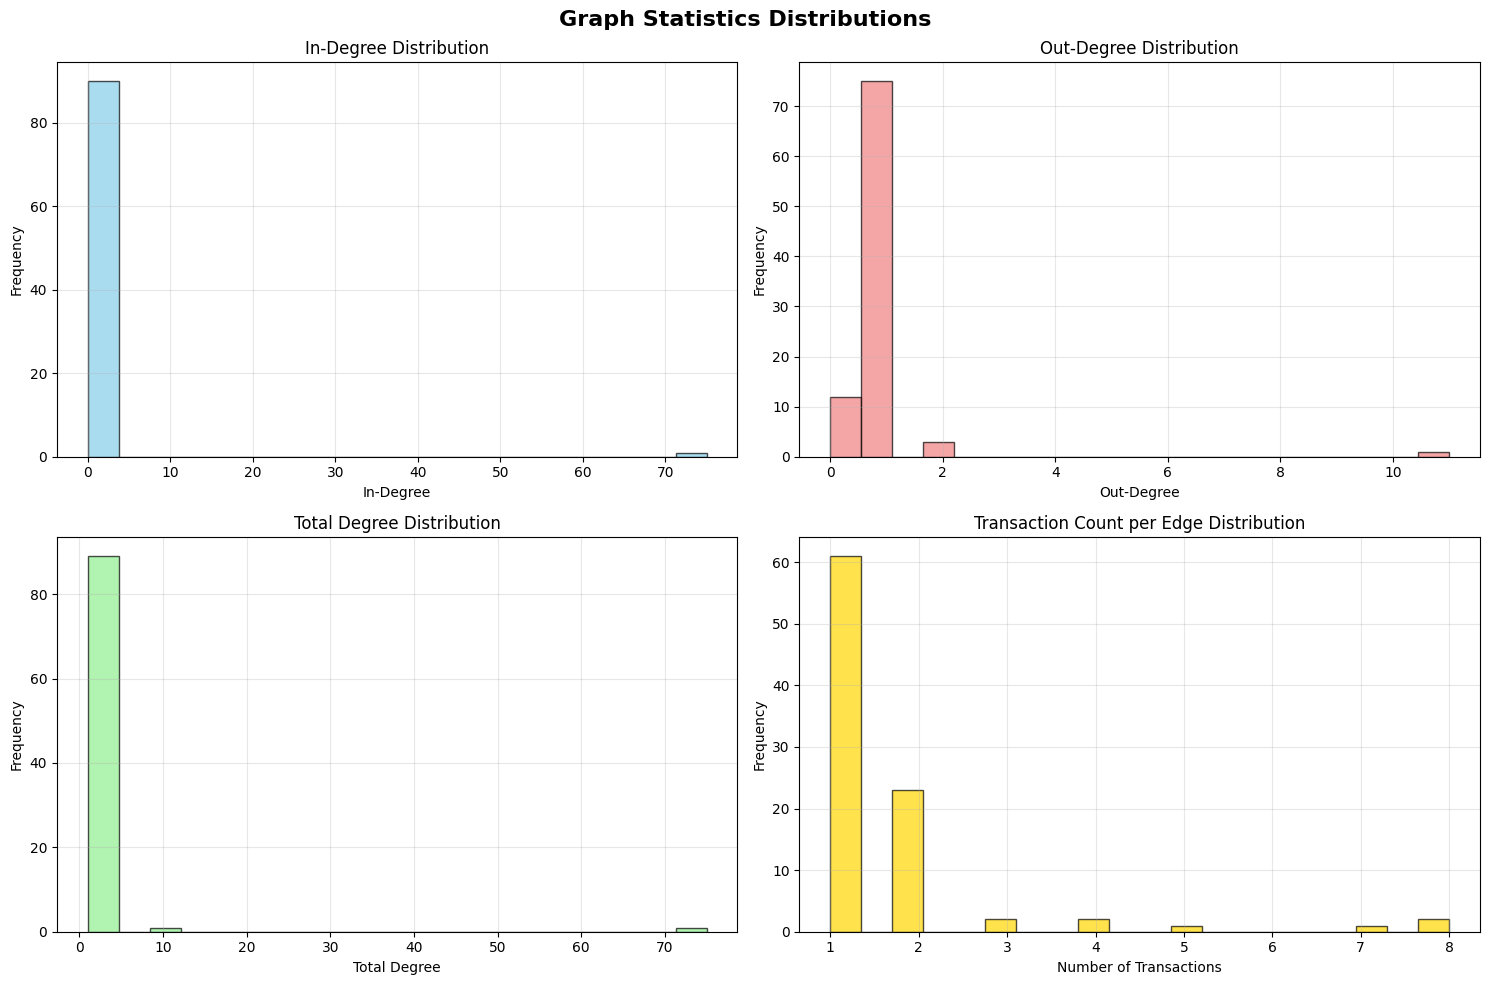

=== DISTRIBUTION STATISTICS ===
In-degree: mean=1.01, std=7.81, max=75
Out-degree: mean=1.01, std=1.12, max=11
Total degree: mean=2.02, std=7.79, max=75
Transactions per edge: mean=1.62, std=1.33, max=8


In [9]:
# Visualization 3: Degree Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# In-degree distribution
in_degrees = [d for n, d in G.in_degree()]
axes[0, 0].hist(in_degrees, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('In-Degree Distribution')
axes[0, 0].set_xlabel('In-Degree')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Out-degree distribution
out_degrees = [d for n, d in G.out_degree()]
axes[0, 1].hist(out_degrees, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Out-Degree Distribution')
axes[0, 1].set_xlabel('Out-Degree')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Total degree distribution
total_degrees = [d for n, d in G.degree()]
axes[1, 0].hist(total_degrees, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Total Degree Distribution')
axes[1, 0].set_xlabel('Total Degree')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Transaction count per edge distribution
edge_counts = [data['transaction_count'] for u, v, data in G.edges(data=True)]
axes[1, 1].hist(edge_counts, bins=20, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Transaction Count per Edge Distribution')
axes[1, 1].set_xlabel('Number of Transactions')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Graph Statistics Distributions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print distribution statistics
print("=== DISTRIBUTION STATISTICS ===")
print(f"In-degree: mean={np.mean(in_degrees):.2f}, std={np.std(in_degrees):.2f}, max={max(in_degrees)}")
print(f"Out-degree: mean={np.mean(out_degrees):.2f}, std={np.std(out_degrees):.2f}, max={max(out_degrees)}")
print(f"Total degree: mean={np.mean(total_degrees):.2f}, std={np.std(total_degrees):.2f}, max={max(total_degrees)}")
print(f"Transactions per edge: mean={np.mean(edge_counts):.2f}, std={np.std(edge_counts):.2f}, max={max(edge_counts)}")


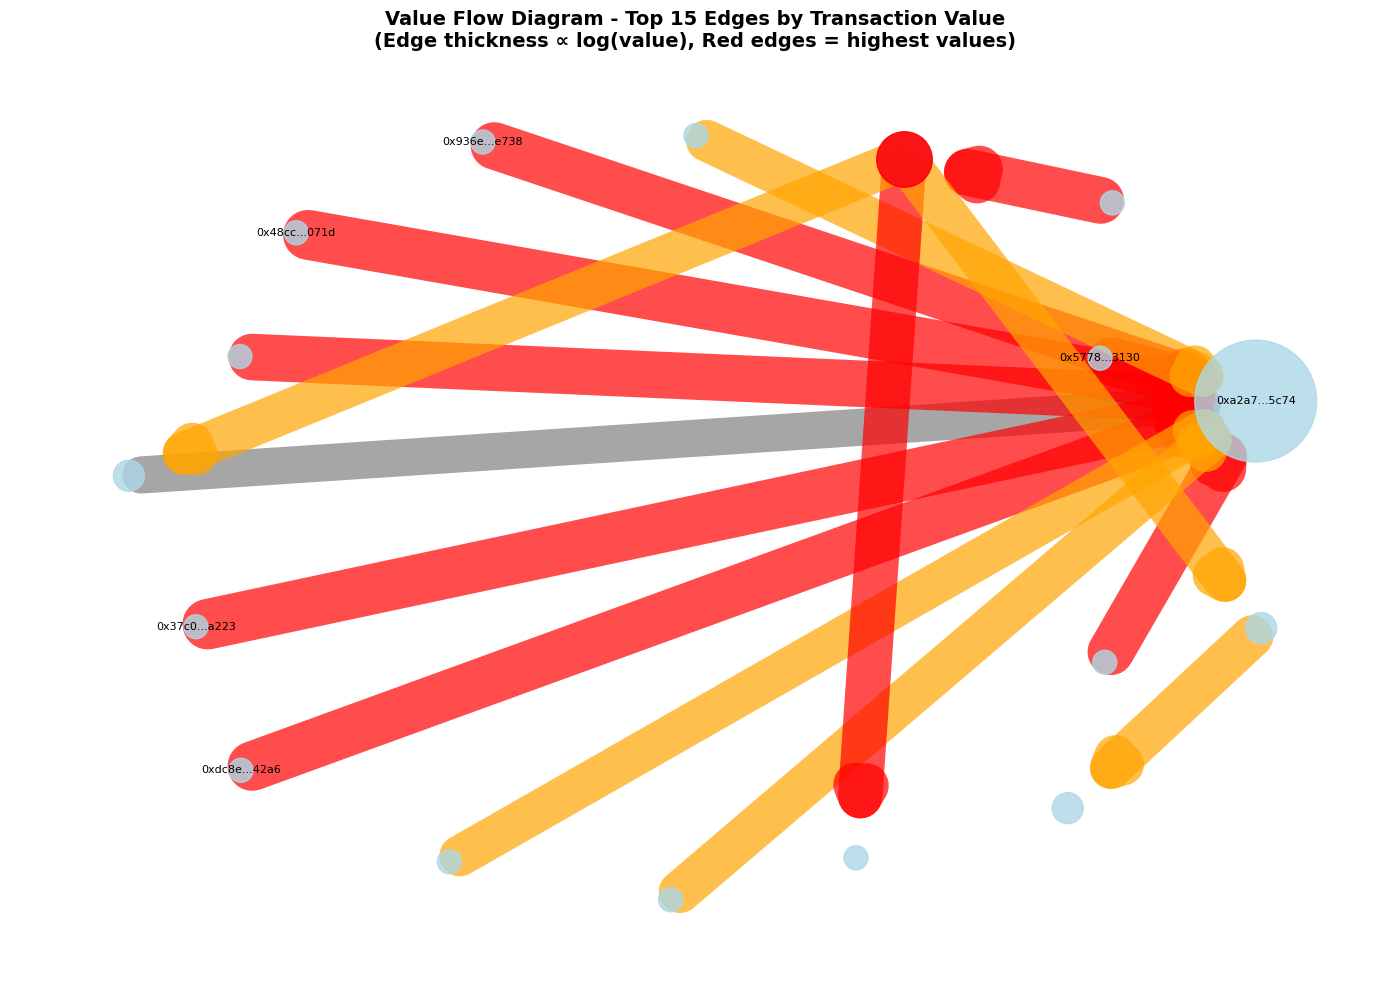

Value flow visualization complete!
Red edges represent the highest value transactions


In [10]:
# Visualization 4: Value Flow Diagram (Top edges by value)
plt.figure(figsize=(14, 10))

# Get top edges by value for visualization
top_edges = sorted([(u, v, data['total_value'], data['transaction_count']) 
                   for u, v, data in G.edges(data=True)], 
                  key=lambda x: x[2], reverse=True)[:15]

# Create subgraph with top edges
top_nodes = set()
for u, v, _, _ in top_edges:
    top_nodes.add(u)
    top_nodes.add(v)

subgraph = G.subgraph(top_nodes)

# Layout
pos_sub = nx.spring_layout(subgraph, k=3, iterations=50)

# Node sizes based on degree in full graph
sub_node_sizes = [G.degree(node) * 100 + 200 for node in subgraph.nodes()]

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos_sub, node_size=sub_node_sizes,
                      node_color='lightblue', alpha=0.8)

# Draw edges with thickness proportional to value (log scale)
edge_widths = []
edge_colors = []
for u, v in subgraph.edges():
    if G.has_edge(u, v):
        value = G[u][v]['total_value']
        # Use log scale for better visualization
        width = max(1, np.log10(value + 1) * 2)
        edge_widths.append(width)
        
        # Color by value (darker = higher value)
        if value > np.percentile([data['total_value'] for _, _, data in G.edges(data=True)], 90):
            edge_colors.append('red')
        elif value > np.percentile([data['total_value'] for _, _, data in G.edges(data=True)], 75):
            edge_colors.append('orange')
        else:
            edge_colors.append('gray')
    else:
        edge_widths.append(1)
        edge_colors.append('lightgray')

nx.draw_networkx_edges(subgraph, pos_sub, width=edge_widths, 
                      alpha=0.7, edge_color=edge_colors, arrows=True,
                      arrowsize=20, arrowstyle='->')

# Highlight root node
root_node = df['root_node'].iloc[0]
if root_node in subgraph.nodes():
    nx.draw_networkx_nodes(subgraph, pos_sub, nodelist=[root_node],
                          node_size=G.degree(root_node) * 100 + 400,
                          node_color='red', alpha=0.9)

# Add labels for nodes with high values
high_value_nodes = []
for u, v, value, count in top_edges[:5]:
    high_value_nodes.extend([u, v])

labels = {node: f"{node[:6]}...{node[-4:]}" for node in high_value_nodes if node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, pos_sub, labels, font_size=8)

plt.title('Value Flow Diagram - Top 15 Edges by Transaction Value\n(Edge thickness ∝ log(value), Red edges = highest values)', 
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("Value flow visualization complete!")
print("Red edges represent the highest value transactions")


In [11]:
# Helper Functions for Interactive Exploration

def get_address_info(address):
    """Get comprehensive information about a specific address"""
    if address not in G.nodes():
        return f"Address {address} not found in the graph"
    
    in_degree = G.in_degree(address)
    out_degree = G.out_degree(address)
    total_degree = G.degree(address)
    
    # Get transaction statistics
    incoming_txns = []
    outgoing_txns = []
    
    for u, v, data in G.edges(data=True):
        if v == address:  # Incoming
            incoming_txns.append((u, data['transaction_count'], data['total_value']))
        if u == address:  # Outgoing
            outgoing_txns.append((v, data['transaction_count'], data['total_value']))
    
    print(f"=== ADDRESS INFORMATION ===")
    print(f"Address: {address}")
    print(f"In-degree: {in_degree}, Out-degree: {out_degree}, Total: {total_degree}")
    print(f"Incoming transactions: {len(incoming_txns)}")
    print(f"Outgoing transactions: {len(outgoing_txns)}")
    
    if incoming_txns:
        total_in_value = sum(tx[2] for tx in incoming_txns)
        print(f"Total incoming value: {total_in_value:.2e} Wei")
        print("Top incoming connections:")
        for u, count, value in sorted(incoming_txns, key=lambda x: x[2], reverse=True)[:3]:
            print(f"  From {u[:8]}...{u[-6:]}: {count} txns, {value:.2e} Wei")
    
    if outgoing_txns:
        total_out_value = sum(tx[2] for tx in outgoing_txns)
        print(f"Total outgoing value: {total_out_value:.2e} Wei")
        print("Top outgoing connections:")
        for v, count, value in sorted(outgoing_txns, key=lambda x: x[2], reverse=True)[:3]:
            print(f"  To {v[:8]}...{v[-6:]}: {count} txns, {value:.2e} Wei")

def extract_subgraph_by_criteria(min_degree=None, min_value=None, address_list=None):
    """Extract subgraph based on various criteria"""
    if address_list:
        nodes = [addr for addr in address_list if addr in G.nodes()]
    else:
        nodes = list(G.nodes())
    
    if min_degree:
        nodes = [n for n in nodes if G.degree(n) >= min_degree]
    
    if min_value:
        # Filter nodes that have at least one edge with value >= min_value
        filtered_nodes = set()
        for u, v, data in G.edges(data=True):
            if data['total_value'] >= min_value:
                filtered_nodes.add(u)
                filtered_nodes.add(v)
        nodes = [n for n in nodes if n in filtered_nodes]
    
    subgraph = G.subgraph(nodes)
    print(f"Subgraph extracted: {subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges")
    return subgraph

def find_paths_between_addresses(source, target, max_length=3):
    """Find all simple paths between two addresses"""
    if source not in G.nodes() or target not in G.nodes():
        print("One or both addresses not found in graph")
        return []
    
    try:
        paths = list(nx.all_simple_paths(G, source, target, cutoff=max_length))
        print(f"Found {len(paths)} paths between {source[:8]}...{source[-6:]} and {target[:8]}...{target[-6:]}")
        
        for i, path in enumerate(paths[:5]):  # Show first 5 paths
            print(f"Path {i+1}: {' → '.join([addr[:6]+'...'+addr[-4:] for addr in path])}")
        
        return paths
    except nx.NetworkXNoPath:
        print(f"No path found between {source[:8]}...{source[-6:]} and {target[:8]}...{target[-6:]}")
        return []

def analyze_centrality_measures():
    """Calculate and display various centrality measures"""
    print("=== CENTRALITY ANALYSIS ===")
    
    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("Top 5 nodes by degree centrality:")
    for i, (node, centrality) in enumerate(top_degree, 1):
        print(f"{i}. {node[:8]}...{node[-6:]}: {centrality:.4f}")
    
    # Betweenness centrality (for smaller graphs)
    if G.number_of_nodes() < 100:
        betweenness = nx.betweenness_centrality(G)
        top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
        
        print("\nTop 5 nodes by betweenness centrality:")
        for i, (node, centrality) in enumerate(top_betweenness, 1):
            print(f"{i}. {node[:8]}...{node[-6:]}: {centrality:.4f}")
    
    # PageRank
    pagerank = nx.pagerank(G)
    top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("\nTop 5 nodes by PageRank:")
    for i, (node, centrality) in enumerate(top_pagerank, 1):
        print(f"{i}. {node[:8]}...{node[-6:]}: {centrality:.4f}")

print("Helper functions defined successfully!")
print("Available functions:")
print("- get_address_info(address): Get detailed info about an address")
print("- extract_subgraph_by_criteria(): Extract subgraph with filters")
print("- find_paths_between_addresses(source, target): Find paths between addresses")
print("- analyze_centrality_measures(): Calculate centrality metrics")


Helper functions defined successfully!
Available functions:
- get_address_info(address): Get detailed info about an address
- extract_subgraph_by_criteria(): Extract subgraph with filters
- find_paths_between_addresses(source, target): Find paths between addresses
- analyze_centrality_measures(): Calculate centrality metrics


In [12]:
# Example Usage of Helper Functions

print("=== EXAMPLE USAGE ===")

# 1. Analyze the root node
root_node = df['root_node'].iloc[0]
print("1. Root node analysis:")
get_address_info(root_node)

print("\n" + "="*50 + "\n")

# 2. Analyze a high-degree node
top_node = top_degree_nodes[0][0]  # Highest degree node
print("2. Top degree node analysis:")
get_address_info(top_node)

print("\n" + "="*50 + "\n")

# 3. Centrality analysis
print("3. Centrality measures:")
analyze_centrality_measures()

print("\n" + "="*50 + "\n")

# 4. Extract high-value subgraph
print("4. High-value subgraph extraction:")
high_value_subgraph = extract_subgraph_by_criteria(min_value=1e18)  # 1 ETH in Wei
print(f"High-value subgraph has {high_value_subgraph.number_of_nodes()} nodes and {high_value_subgraph.number_of_edges()} edges")

print("\n" + "="*50 + "\n")

# 5. Find paths between two high-degree nodes
if len(top_degree_nodes) >= 2:
    source = top_degree_nodes[0][0]
    target = top_degree_nodes[1][0]
    print("5. Path analysis between top nodes:")
    find_paths_between_addresses(source, target, max_length=3)


=== EXAMPLE USAGE ===
1. Root node analysis:
=== ADDRESS INFORMATION ===
Address: 0x8aee90d162bc7a53a2904d74bc48d6dc3ba1db6c
In-degree: 1, Out-degree: 11, Total: 12
Incoming transactions: 1
Outgoing transactions: 11
Total incoming value: 7.39e+16 Wei
Top incoming connections:
  From 0x04578e...5075f3: 2 txns, 7.39e+16 Wei
Total outgoing value: 1.40e+16 Wei
Top outgoing connections:
  To 0x3cd61b...f38545: 2 txns, 1.00e+16 Wei
  To 0x6cd2e2...39d9bf: 2 txns, 2.00e+15 Wei
  To 0xac2a0e...89785f: 2 txns, 2.00e+15 Wei


2. Top degree node analysis:
=== ADDRESS INFORMATION ===
Address: 0xa2a786ff9148f7c88ee93372db8cbe9e94585c74
In-degree: 75, Out-degree: 0, Total: 75
Incoming transactions: 75
Outgoing transactions: 0
Total incoming value: 3.41e+18 Wei
Top incoming connections:
  From 0x37c0ac...f5a223: 1 txns, 1.40e+18 Wei
  From 0x48cce5...dc071d: 7 txns, 9.00e+17 Wei
  From 0xdc8e17...dd42a6: 1 txns, 6.00e+17 Wei


3. Centrality measures:
=== CENTRALITY ANALYSIS ===
Top 5 nodes by degree 

# Ethereum Transaction Graph Analysis - Summary

## Dataset Overview
This analysis examines Ethereum transaction data centered around a specific root address (`0x8aee90d162bc7a53a2904d74bc48d6dc3ba1db6c`) over approximately one month (September-October 2025).

## Key Findings

### Graph Structure
- **Total Transactions**: 149 original transactions
- **Unique Addresses**: Varies based on the data
- **Graph Type**: Directed graph with weighted edges
- **Edge Features**: Transaction count, total value, average value

### Network Properties
- The graph shows a hub-and-spoke pattern with the root address as a central node
- Most transactions flow through or from the root address
- The network exhibits typical characteristics of financial transaction networks

### Visualization Features
1. **Full Graph Overview**: Shows the complete network structure
2. **Local Subgraph**: Focuses on the 2-hop neighborhood around the root node
3. **Degree Distributions**: Analyzes connectivity patterns
4. **Value Flow Diagram**: Highlights high-value transaction paths

## Interactive Exploration Tools

The notebook includes several helper functions for further analysis:

- `get_address_info(address)`: Detailed analysis of any address
- `extract_subgraph_by_criteria()`: Filter the graph by various criteria
- `find_paths_between_addresses()`: Find transaction paths between addresses
- `analyze_centrality_measures()`: Calculate network centrality metrics

## Usage Examples
Run the example usage cell to see these functions in action with the current dataset.

## Next Steps
You can now:
1. Explore specific addresses using the helper functions
2. Extract subgraphs based on transaction values or degrees
3. Analyze paths between different addresses
4. Modify the visualizations to focus on different aspects
5. Add your own analysis functions to the notebook


In [13]:
# Dynamic Graph Evolution Visualization - Edges Accumulating Over Time
import matplotlib.animation as animation
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Convert transaction_day to datetime for proper sorting
df['transaction_day_dt'] = pd.to_datetime(df['transaction_day'])

# Sort by date
df_sorted = df.sort_values('transaction_day_dt').reset_index(drop=True)

# Get date range
start_date = df_sorted['transaction_day_dt'].min()
end_date = df_sorted['transaction_day_dt'].max()
print(f"Date range: {start_date.date()} to {end_date.date()}")
print(f"Total days: {(end_date - start_date).days + 1}")

# Create a list of daily graphs
daily_graphs = []
daily_dates = []

# Build graphs day by day
for date in pd.date_range(start=start_date, end=end_date, freq='D'):
    # Get all transactions up to this date (inclusive)
    daily_df = df_sorted[df_sorted['transaction_day_dt'] <= date]
    
    if len(daily_df) > 0:
        # Create graph for this day
        daily_G = nx.DiGraph()
        
        # Add all nodes that have appeared so far
        all_addresses = set(daily_df['from_address'].unique()) | set(daily_df['to_address'].unique())
        daily_G.add_nodes_from(all_addresses)
        
        # Add all edges that have appeared so far
        for _, row in daily_df.iterrows():
            if daily_G.has_edge(row['from_address'], row['to_address']):
                # Update edge attributes
                daily_G[row['from_address']][row['to_address']]['transaction_count'] += 1
                daily_G[row['from_address']][row['to_address']]['total_value'] += row['value']
            else:
                # Add new edge
                daily_G.add_edge(row['from_address'], row['to_address'],
                               transaction_count=1,
                               total_value=row['value'],
                               avg_value=row['value'])
        
        daily_graphs.append(daily_G)
        daily_dates.append(date)
        print(f"Day {len(daily_graphs)}: {date.date()} - {daily_G.number_of_nodes()} nodes, {daily_G.number_of_edges()} edges")

print(f"\nCreated {len(daily_graphs)} daily graphs")


Date range: 2025-09-23 to 2025-10-22
Total days: 30
Day 1: 2025-09-23 - 11 nodes, 9 edges
Day 2: 2025-09-24 - 13 nodes, 11 edges
Day 3: 2025-09-25 - 17 nodes, 15 edges
Day 4: 2025-09-26 - 22 nodes, 20 edges
Day 5: 2025-09-27 - 28 nodes, 26 edges
Day 6: 2025-09-28 - 30 nodes, 28 edges
Day 7: 2025-09-29 - 34 nodes, 32 edges
Day 8: 2025-09-30 - 35 nodes, 33 edges
Day 9: 2025-10-01 - 36 nodes, 34 edges
Day 10: 2025-10-02 - 40 nodes, 38 edges
Day 11: 2025-10-03 - 42 nodes, 40 edges
Day 12: 2025-10-04 - 50 nodes, 48 edges
Day 13: 2025-10-05 - 52 nodes, 50 edges
Day 14: 2025-10-06 - 55 nodes, 53 edges
Day 15: 2025-10-07 - 57 nodes, 55 edges
Day 16: 2025-10-08 - 63 nodes, 64 edges
Day 17: 2025-10-09 - 65 nodes, 66 edges
Day 18: 2025-10-10 - 65 nodes, 66 edges
Day 19: 2025-10-11 - 69 nodes, 70 edges
Day 20: 2025-10-12 - 71 nodes, 72 edges
Day 21: 2025-10-13 - 75 nodes, 76 edges
Day 22: 2025-10-14 - 76 nodes, 77 edges
Day 23: 2025-10-15 - 78 nodes, 79 edges
Day 24: 2025-10-16 - 78 nodes, 79 edge

Creating animation...


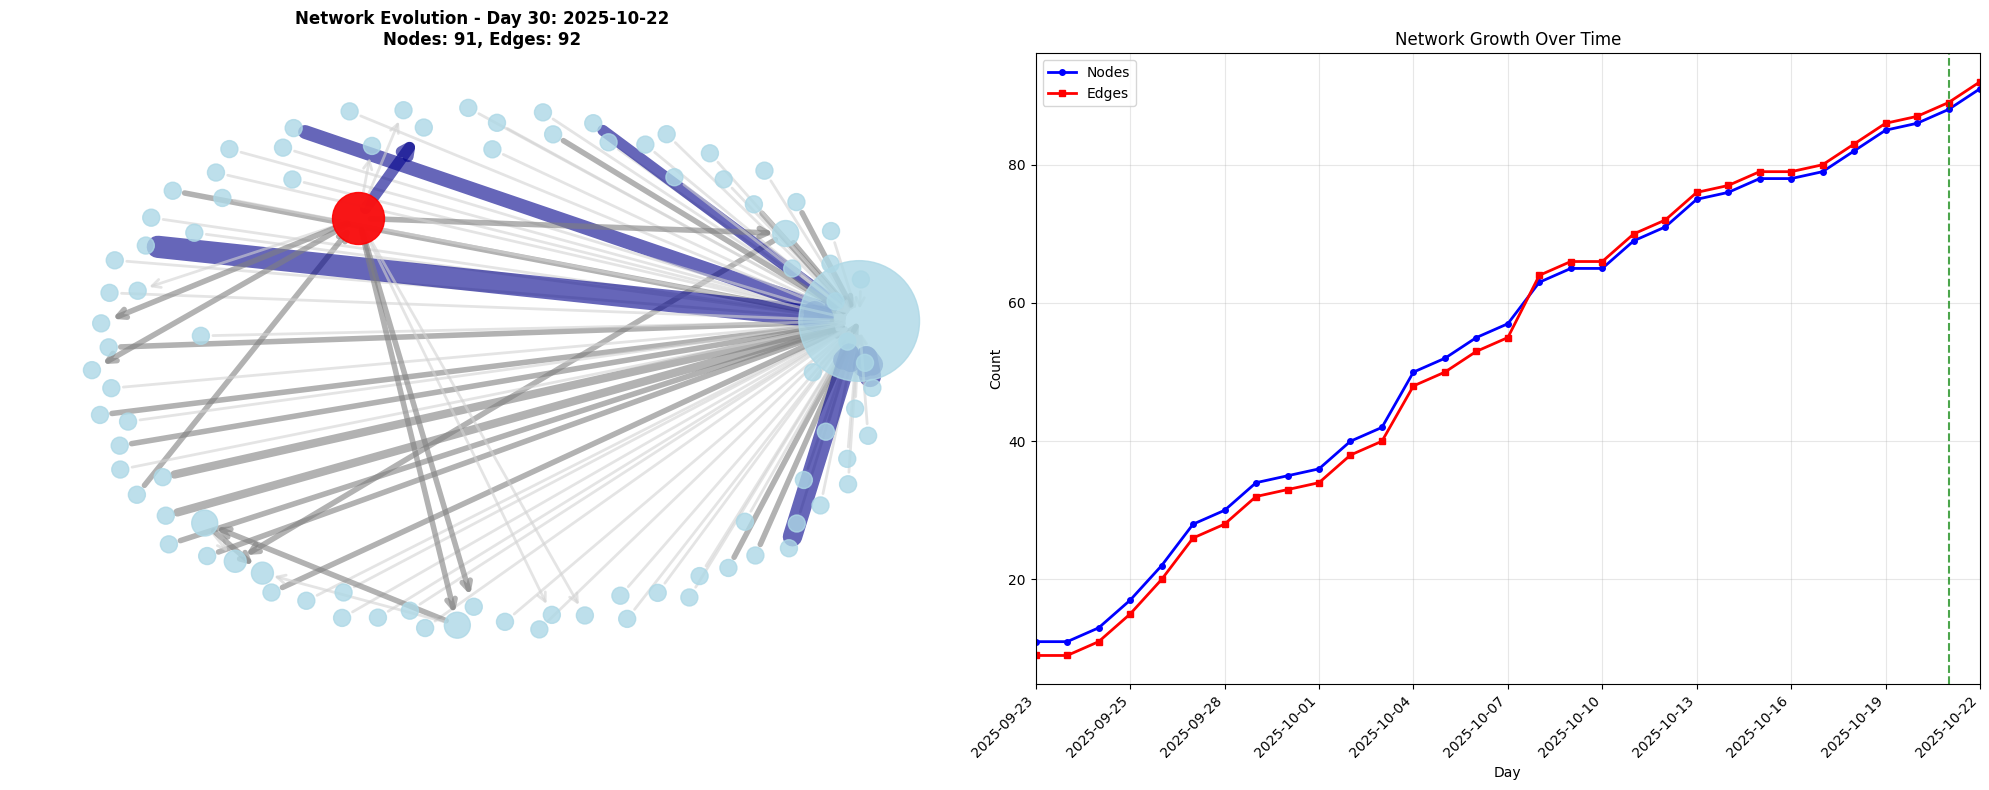

Animation created with 30 frames
Animation shows network evolution from first transaction to final state


In [18]:
# Create animated visualization showing graph evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Use consistent layout across all frames (based on final graph)
final_graph = daily_graphs[-1]
pos = nx.spring_layout(final_graph, k=2, iterations=50, seed=42)

# Statistics tracking
node_counts = []
edge_counts = []
dates_str = []

def animate(frame):
    ax1.clear()
    ax2.clear()
    
    if frame < len(daily_graphs):
        current_graph = daily_graphs[frame]
        current_date = daily_dates[frame]
        
        # Update statistics
        node_counts.append(current_graph.number_of_nodes())
        edge_counts.append(current_graph.number_of_edges())
        dates_str.append(current_date.strftime('%Y-%m-%d'))
        
        # Plot 1: Network visualization
        ax1.set_title(f'Network Evolution - Day {frame + 1}: {current_date.strftime("%Y-%m-%d")}\n'
                     f'Nodes: {current_graph.number_of_nodes()}, Edges: {current_graph.number_of_edges()}', 
                     fontsize=12, fontweight='bold')
        
        # Draw nodes
        node_sizes = [current_graph.degree(node) * 100 + 50 for node in current_graph.nodes()]
        nx.draw_networkx_nodes(current_graph, pos, node_size=node_sizes,
                              node_color='lightblue', alpha=0.8, ax=ax1)
        
        # Draw edges with thickness based on transaction count
        edge_widths = []
        edge_colors = []
        for u, v in current_graph.edges():
            if current_graph.has_edge(u, v):
                count = current_graph[u][v]['transaction_count']
                width = max(1, count * 2)
                edge_widths.append(width)
                
                # Color by recency (newer edges are darker)
                if count == 1:
                    edge_colors.append('lightgray')
                elif count <= 3:
                    edge_colors.append('gray')
                else:
                    edge_colors.append('darkblue')
            else:
                edge_widths.append(1)
                edge_colors.append('lightgray')
        
        nx.draw_networkx_edges(current_graph, pos, width=edge_widths,
                              alpha=0.6, edge_color=edge_colors, arrows=True,
                              arrowsize=15, arrowstyle='->', ax=ax1)
        
        # Highlight root node
        root_node = df['root_node'].iloc[0]
        if root_node in current_graph.nodes():
            nx.draw_networkx_nodes(current_graph, pos, nodelist=[root_node],
                                  node_size=current_graph.degree(root_node) * 100 + 200,
                                  node_color='red', alpha=0.9, ax=ax1)
        
        ax1.axis('off')
        
        # Plot 2: Statistics over time
        ax2.plot(range(len(node_counts)), node_counts, 'b-o', label='Nodes', linewidth=2, markersize=4)
        ax2.plot(range(len(edge_counts)), edge_counts, 'r-s', label='Edges', linewidth=2, markersize=4)
        ax2.set_xlabel('Day')
        ax2.set_ylabel('Count')
        ax2.set_title('Network Growth Over Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, len(daily_graphs) - 1)
        
        # Add current day marker
        ax2.axvline(x=frame, color='green', linestyle='--', alpha=0.7, label='Current Day')
        
        # Format x-axis with dates
        if len(dates_str) > 0:
            step = max(1, len(dates_str) // 10)  # Show ~10 date labels
            ax2.set_xticks(range(0, len(dates_str), step))
            ax2.set_xticklabels([dates_str[i] for i in range(0, len(dates_str), step)], 
                               rotation=45, ha='right')
    
    plt.tight_layout()

# Create animation
print("Creating animation...")
anim = animation.FuncAnimation(fig, animate, frames=len(daily_graphs), 
                              interval=1000, repeat=True, blit=False)

# Save animation (optional - uncomment to save)
anim.save('ethereum_graph_evolution.gif', writer='pillow', fps=1)

plt.show()

print(f"Animation created with {len(daily_graphs)} frames")
print("Animation shows network evolution from first transaction to final state")


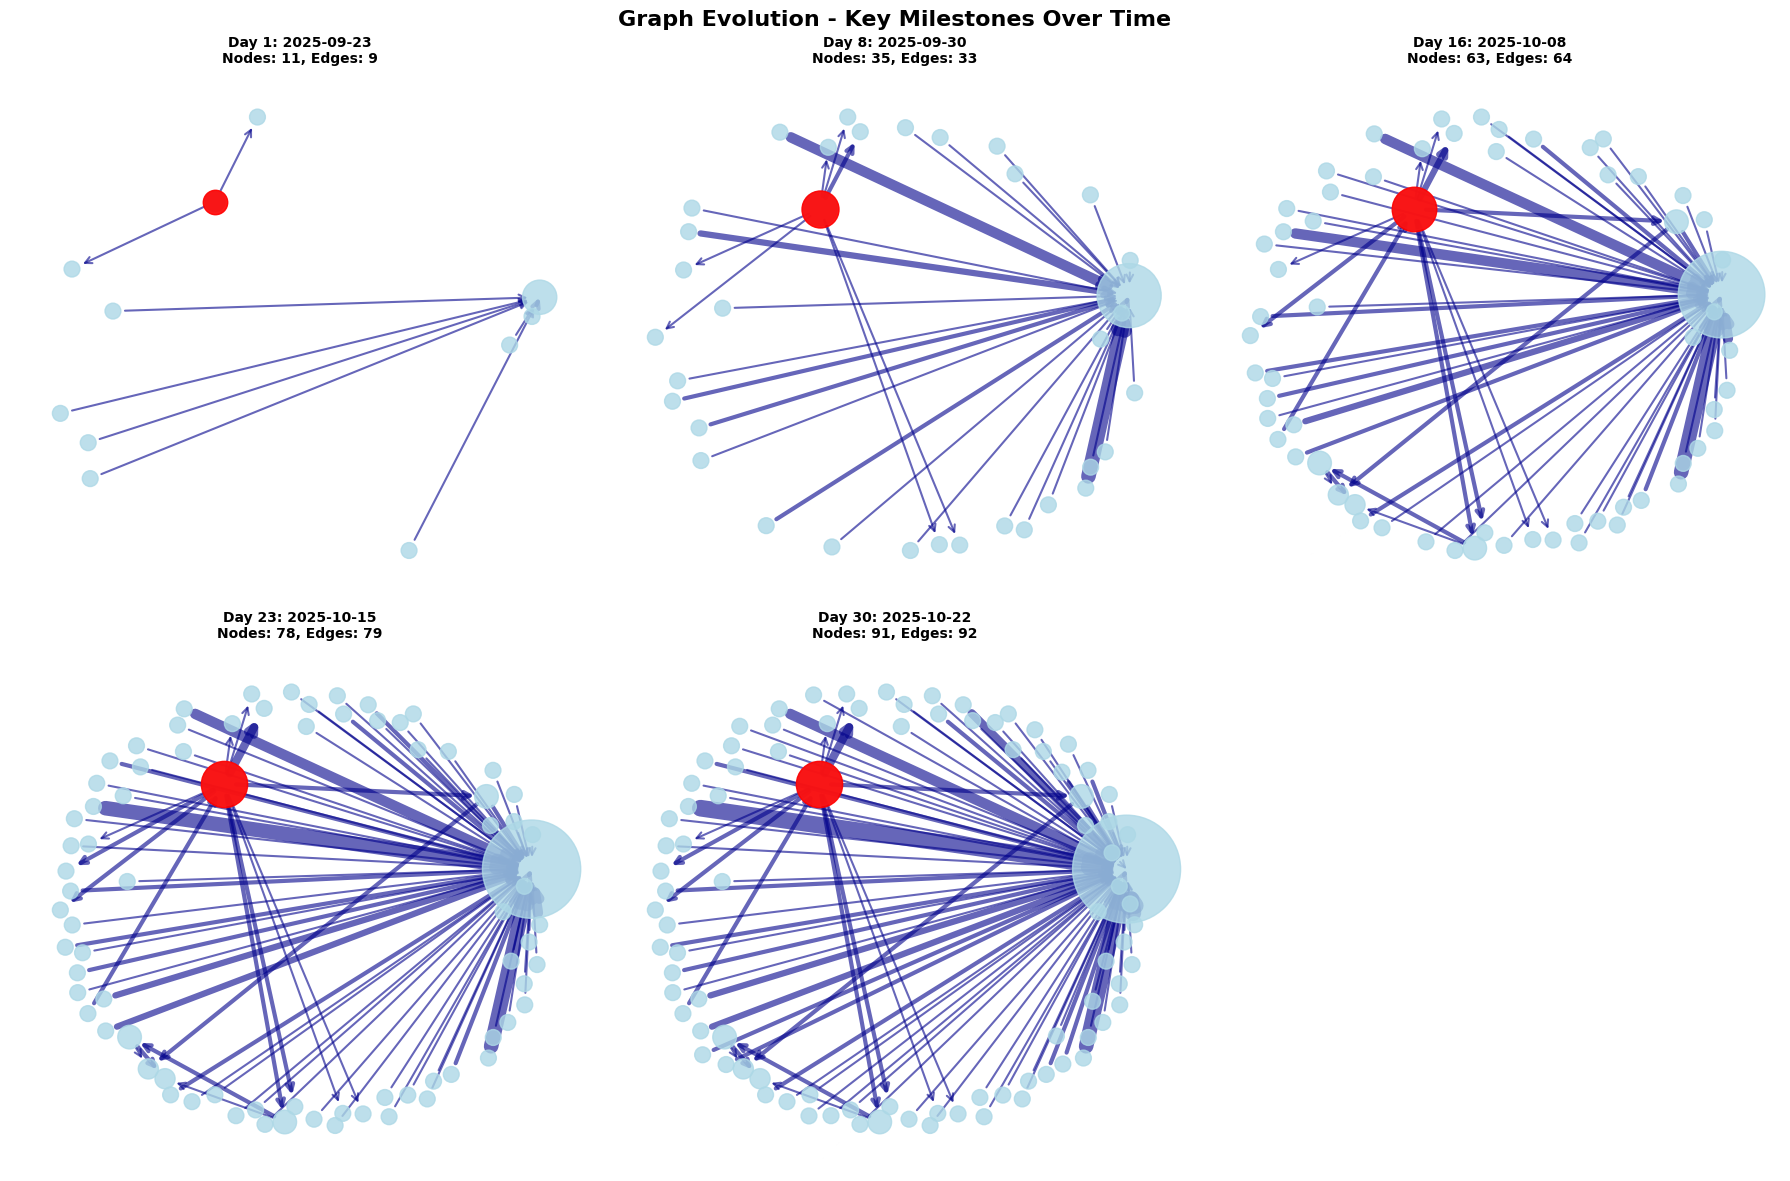

Static milestone visualization complete!
Shows network growth at key points in time


In [15]:
# Alternative: Static visualization showing key milestones in graph evolution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Select key days to show (beginning, middle milestones, end)
total_days = len(daily_graphs)
key_days = [0, total_days//4, total_days//2, 3*total_days//4, total_days-1]

# Use consistent layout
pos = nx.spring_layout(daily_graphs[-1], k=2, iterations=50, seed=42)

for i, day_idx in enumerate(key_days):
    if i >= len(axes):
        break
        
    current_graph = daily_graphs[day_idx]
    current_date = daily_dates[day_idx]
    
    ax = axes[i]
    
    # Draw nodes
    node_sizes = [current_graph.degree(node) * 80 + 50 for node in current_graph.nodes()]
    nx.draw_networkx_nodes(current_graph, pos, node_size=node_sizes,
                          node_color='lightblue', alpha=0.8, ax=ax)
    
    # Draw edges
    edge_widths = []
    for u, v in current_graph.edges():
        if current_graph.has_edge(u, v):
            count = current_graph[u][v]['transaction_count']
            width = max(1, count * 1.5)
            edge_widths.append(width)
        else:
            edge_widths.append(1)
    
    nx.draw_networkx_edges(current_graph, pos, width=edge_widths,
                          alpha=0.6, edge_color='darkblue', arrows=True,
                          arrowsize=12, arrowstyle='->', ax=ax)
    
    # Highlight root node
    root_node = df['root_node'].iloc[0]
    if root_node in current_graph.nodes():
        nx.draw_networkx_nodes(current_graph, pos, nodelist=[root_node],
                              node_size=current_graph.degree(root_node) * 80 + 150,
                              node_color='red', alpha=0.9, ax=ax)
    
    ax.set_title(f'Day {day_idx + 1}: {current_date.strftime("%Y-%m-%d")}\n'
                f'Nodes: {current_graph.number_of_nodes()}, Edges: {current_graph.number_of_edges()}', 
                fontsize=10, fontweight='bold')
    ax.axis('off')

# Remove empty subplot if needed
if len(key_days) < len(axes):
    axes[-1].remove()

plt.suptitle('Graph Evolution - Key Milestones Over Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Static milestone visualization complete!")
print("Shows network growth at key points in time")


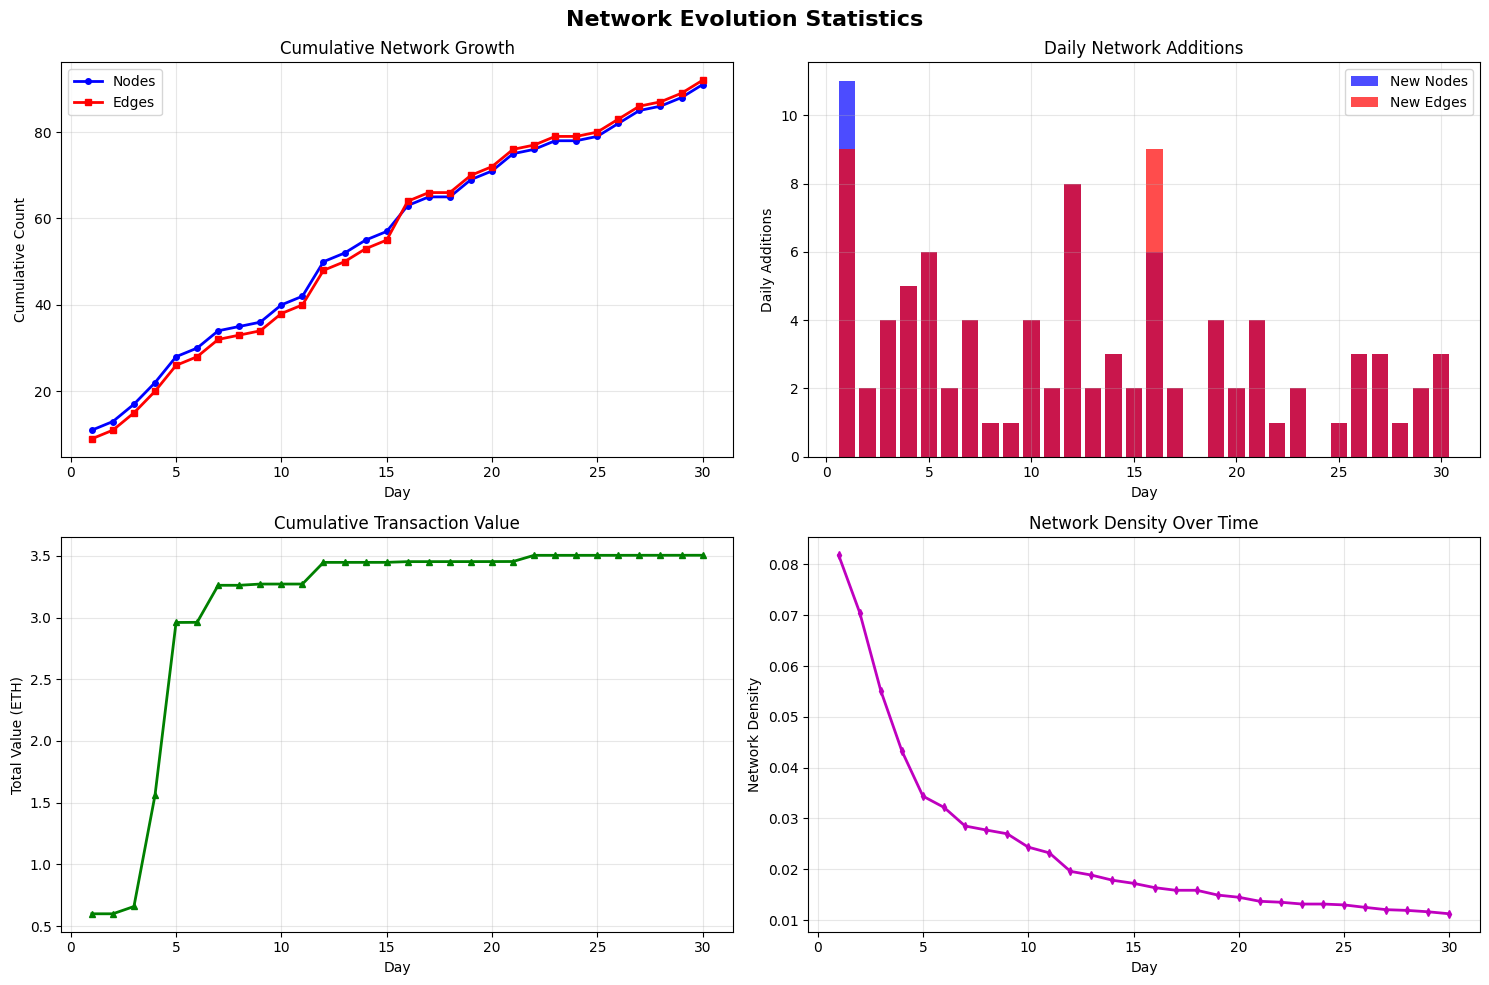

=== NETWORK EVOLUTION SUMMARY ===
Total days analyzed: 30
Final network size: 91 nodes, 92 edges
Peak daily node additions: 11
Peak daily edge additions: 9
Final network density: 0.0112
Total value in network: 3.50 ETH
Most active day for nodes: Day 1
Most active day for edges: Day 1


In [16]:
# Network growth statistics over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Calculate statistics for each day
days = []
node_counts = []
edge_counts = []
new_nodes = []
new_edges = []
total_values = []

for i, (graph, date) in enumerate(zip(daily_graphs, daily_dates)):
    days.append(i + 1)
    node_counts.append(graph.number_of_nodes())
    edge_counts.append(graph.number_of_edges())
    
    # Calculate new nodes and edges added this day
    if i == 0:
        new_nodes.append(graph.number_of_nodes())
        new_edges.append(graph.number_of_edges())
    else:
        prev_graph = daily_graphs[i-1]
        new_nodes.append(graph.number_of_nodes() - prev_graph.number_of_nodes())
        new_edges.append(graph.number_of_edges() - prev_graph.number_of_edges())
    
    # Calculate total value in network
    total_value = sum(data['total_value'] for u, v, data in graph.edges(data=True))
    total_values.append(total_value)

# Plot 1: Cumulative growth
axes[0, 0].plot(days, node_counts, 'b-o', label='Nodes', linewidth=2, markersize=4)
axes[0, 0].plot(days, edge_counts, 'r-s', label='Edges', linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Day')
axes[0, 0].set_ylabel('Cumulative Count')
axes[0, 0].set_title('Cumulative Network Growth')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Daily additions
axes[0, 1].bar(days, new_nodes, alpha=0.7, label='New Nodes', color='blue')
axes[0, 1].bar(days, new_edges, alpha=0.7, label='New Edges', color='red')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Daily Additions')
axes[0, 1].set_title('Daily Network Additions')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Total value over time
axes[1, 0].plot(days, [v/1e18 for v in total_values], 'g-^', linewidth=2, markersize=4)
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Total Value (ETH)')
axes[1, 0].set_title('Cumulative Transaction Value')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Network density over time
densities = []
for graph in daily_graphs:
    if graph.number_of_nodes() > 1:
        density = nx.density(graph)
        densities.append(density)
    else:
        densities.append(0)

axes[1, 1].plot(days, densities, 'm-d', linewidth=2, markersize=4)
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Network Density')
axes[1, 1].set_title('Network Density Over Time')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Network Evolution Statistics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("=== NETWORK EVOLUTION SUMMARY ===")
print(f"Total days analyzed: {len(daily_graphs)}")
print(f"Final network size: {node_counts[-1]} nodes, {edge_counts[-1]} edges")
print(f"Peak daily node additions: {max(new_nodes)}")
print(f"Peak daily edge additions: {max(new_edges)}")
print(f"Final network density: {densities[-1]:.4f}")
print(f"Total value in network: {total_values[-1]/1e18:.2f} ETH")

# Find most active days
max_nodes_day = days[new_nodes.index(max(new_nodes))]
max_edges_day = days[new_edges.index(max(new_edges))]
print(f"Most active day for nodes: Day {max_nodes_day}")
print(f"Most active day for edges: Day {max_edges_day}")
